In [1]:
# import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools

In [2]:
import tensorflow as tf
import csv

def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    # Create a list to store the data rows
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Step', 'Tag', 'Value'])
        # Write the data rows
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")


In [3]:
def tensorboard_to_separate_csv(event_file, output_dir):
    from tensorflow.python.framework.errors_impl import DataLossError
    from collections import defaultdict
    import os, csv
    
    tag_data = defaultdict(list)
    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.HasField('simple_value'):
                    tag = v.tag
                    value = v.simple_value
                    step = e.step
                    tag_data[tag].append([step, value])
    except DataLossError:
        print(f"Skipped corrupted file: {event_file}")
        return  # Exit this function for corrupted file

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")



In [4]:
def tensorboard_to_separate_csv(event_file, output_dir):
    from tensorflow.python.framework.errors_impl import DataLossError
    from collections import defaultdict
    import os, csv
    import tensorflow as tf

    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                # Process individual records
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                # Log a warning and skip problematic records
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        # Log and continue for files with partial writes
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")


In [5]:
import os
import time

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Loop through all subdirectories of a parent directory, process TensorBoard files,
    and save results to a corresponding directory structure.

    Args:
        parent_dir (str): Parent directory containing TensorBoard event files.
        output_parent_dir (str): Parent directory where CSV files should be saved.
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:  # Check if the file is a TensorBoard event file
                # Full path to the event file
                event_file = os.path.join(root, file)

                # Recreate the directory structure in the output directory
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)

                # Create the output directory if it doesn't exist
                os.makedirs(output_dir, exist_ok=True)

                # Process the TensorBoard event file
                tensorboard_to_separate_csv(event_file, output_dir)

                print(f"Processed {event_file} -> {output_dir}")

In [6]:
def is_file_stable(file_path, wait_time=1.0):
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Loop through all subdirectories of a parent directory, process TensorBoard files,
    and save results to a corresponding directory structure.

    Args:
        parent_dir (str): Parent directory containing TensorBoard event files.
        output_parent_dir (str): Parent directory where CSV files should be saved.
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:  # Check if the file is a TensorBoard event file
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                # Check if the file is stable
                # if not is_file_stable(event_file):
                #     print(f"File is still being written: {event_file}, skipping.")
                #     continue

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")

In [7]:
def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data.
        alpha (float): The smoothing factor (0 < alpha <= 1).

    Returns:
        numpy.ndarray: The EMA values.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]  # Initialize EMA with the first data point
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)


def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.ndarray: The rolling average values.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    # Use np.convolve for efficient computation
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

def plot_average_trajectory(time_series, error_type='std', time_points=None, xlabel='Time', ylabel='Value', title='Average Trajectory'):
    """
    Plots the average trajectory of a set of time series with error bars.

    Parameters:
    - time_series (2D array-like): A set of time series, shape (n_series, n_time_points).
    - error_type (str): Either 'std' for standard deviation or 'sem' for standard error.
    - time_points (1D array-like, optional): Time points corresponding to the time series. Defaults to indices.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.
    """
    time_series = np.array(time_series)
    if time_points is None:
        time_points = np.arange(time_series.shape[1])
    else:
        time_points = np.array(time_points)
    
    if time_series.shape[1] != len(time_points):
        raise ValueError("Length of time_points must match the number of columns in time_series.")
    
    # Compute average and error
    mean_trajectory = np.mean(time_series, axis=0)
    if error_type == 'std':
        error = np.std(time_series, axis=0)
    elif error_type == 'sem':
        error = np.std(time_series, axis=0) / np.sqrt(time_series.shape[0])
    else:
        raise ValueError("error_type must be 'std' or 'sem'.")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory', color='blue')
    plt.fill_between(time_points, mean_trajectory - error, mean_trajectory + error, alpha=0.3, color='blue', label='Error')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.show()



def coefficient_of_variation(timestamps):
    """
    Calculate the coefficient of variation (CV) of inter-visit intervals.
    
    Parameters:
    - timestamps: A list or array of timestamps representing the times of visits or events.
    
    Returns:
    - CV: The coefficient of variation (standard deviation / mean) of inter-visit intervals.
    """
    # Calculate the inter-visit intervals (differences between consecutive timestamps)
    inter_visit_intervals = np.diff(timestamps)
    
    # Calculate the mean and standard deviation of the inter-visit intervals
    mean_interval = np.mean(inter_visit_intervals)
    std_dev_interval = np.std(inter_visit_intervals)
    
    # Calculate the coefficient of variation (CV)
    cv = std_dev_interval / mean_interval
    return cv


def fourier_transform_periodicity(data):
    """
    Perform a Fourier Transform to find the dominant frequency and quantify periodicity.
    
    Parameters:
    - data: A list or array representing the time series data.
    
    Returns:
    - dominant_period: The period corresponding to the dominant frequency.
    - power_at_dominant_frequency: The strength of the dominant frequency.
    """
    # Compute the Fast Fourier Transform (FFT)
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data))
    
    # Compute the absolute value of the FFT (power spectrum)
    power = np.abs(fft_result)
    
    # Find the dominant frequency (highest peak in the power spectrum)
    dominant_frequency = frequencies[np.argmax(power)]
    dominant_period = 1 / dominant_frequency
    
    # Return dominant period and power at that frequency
    return dominant_period, power[np.argmax(power)]



convert tensorboard results

In [52]:
# clean data
parent_dir = '../runs'
output_dir = 'res'
process_tensorboard_results(parent_dir, output_dir)

Data for tag 'Agent_0/Loss' has been written to res/Study1_experiment_cond_check_extreme_improved_punishment_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250612-20061749775825/Agent_0_Loss_data.csv
Data for tag 'Agent_0/Reward' has been written to res/Study1_experiment_cond_check_extreme_improved_punishment_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250612-20061749775825/Agent_0_Reward_data.csv
Data for tag 'Agent_0/Epsilon' has been written to res/Study1_experiment_cond_check_extreme_improved_punishment_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250612-20061749775825/Agent_0_Epsilon_data.csv
Data for tag 'Agent_0/vote_for_punishment' has been written to res/Study1_experiment_cond_check_extreme_improved_punishment_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250612-20061749775825/Agent_0_vote_for_punishme

In [10]:
def trim_and_calculate_mean(array_list):
    # Find the minimum length among all arrays
    min_length = min(len(arr) for arr in array_list)
    
    # Trim each array to the minimum length
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    
    # Convert to a NumPy array for vectorized mean calculation
    trimmed_arrays = np.array(trimmed_arrays)
    
    return trimmed_arrays

In [27]:
from scipy.stats import pearsonr, spearmanr


In [103]:
folders = [
    'test_study1__dynamic_v2_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250314-13031741973615',
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed2_20250312-13031741801097',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed2_20250312-13031741801274',
]

collective_authoritarianism = [[] for _ in range(len(folders))]
collective_transgressions = [[] for _ in range(len(folders))]
collective_d_prime = [[] for _ in range(len(folders))]
collective_coin = [[] for _ in range(len(folders))]
collective_gem= [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'state_punishment_level_avg' in f:
        # if 'd_prime' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_authoritarianism[ixs].append(data['Value'].to_numpy()[:])
        if 'Bone' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective_transgressions[ixs].append(data['Value'].to_numpy()[:])
        if 'Gem' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective_gem[ixs].append(data['Value'].to_numpy()[:])
        if 'Coin' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective_coin[ixs].append(data['Value'].to_numpy()[:])
        if 'd_prime' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_d_prime[ixs].append(data['Value'].to_numpy()[:])
collective_authoritarianism_ = [np.mean(trim_and_calculate_mean(collective_authoritarianism[i]), axis=0) 
                  for i in range(len(collective_authoritarianism))]
collective_transgressions_ = [np.mean(trim_and_calculate_mean(collective_transgressions[i]), axis=0) 
                  for i in range(len(collective_transgressions))]
collective_d_prime_ = [np.mean(trim_and_calculate_mean(collective_d_prime[i]), axis=0) 
                  for i in range(len(collective_d_prime))]
collective_gem_ = [np.mean(trim_and_calculate_mean(collective_gem[i]), axis=0) 
                  for i in range(len(collective_gem))]
collective_coin_ = [np.mean(trim_and_calculate_mean(collective_coin[i]), axis=0) 
                  for i in range(len(collective_coin))]
print(collective_authoritarianism_, len(collective_authoritarianism_[0]))
print(collective_transgressions_, len(collective_transgressions_[0]))

[array([0.82200003, 0.102     , 0.82999998, ..., 0.96799999, 0.77999997,
       0.95599997]), array([0.85600001, 0.75199997, 0.958     , ..., 0.972     , 0.98000002,
       0.94      ]), array([0.736     , 0.80199999, 0.81400001, ..., 0.198     , 0.51599997,
       0.25600001])] 61617
[array([2.        , 1.        , 1.66666667, ..., 0.66666667, 1.33333333,
       0.        ]), array([1.33333333, 1.33333333, 1.66666667, ..., 0.        , 0.        ,
       1.        ]), array([6.        , 3.33333333, 5.        , ..., 5.33333333, 2.66666667,
       2.66666667])] 61610


In [99]:
folders = [
    'test_study1__dynamic_v2_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250314-13031741973615',
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed2_20250312-13031741801097',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed2_20250312-13031741801274',
]

collective_authoritarianism = [[] for _ in range(len(folders))]
collective_transgressions = [[] for _ in range(len(folders))]
collective_d_prime = [[] for _ in range(len(folders))]
collective_coin = [[] for _ in range(len(folders))]
collective_gem= [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'vote_for_punishment' in f:
        # if 'd_prime' in f:
            if 'Agent_0' in f:
                data = pd.read_csv(os.path.join(parent_dir, f))
                collective_authoritarianism[ixs].append(data['Value'].to_numpy()[:])
        if 'Bone' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            if 'Agent_0' in file:
                data = pd.read_csv(os.path.join(sub_dir, file))
                collective_transgressions[ixs].append(data['Value'].to_numpy()[:])
        if 'Gem' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            if 'Agent_0' in file:
                data = pd.read_csv(os.path.join(sub_dir, file))
                collective_gem[ixs].append(data['Value'].to_numpy()[:])
        if 'Coin' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            if 'Agent_0' in file:
                data = pd.read_csv(os.path.join(sub_dir, file))
                collective_coin[ixs].append(data['Value'].to_numpy()[:])
        # if 'd_prime' in f:
        #     data = pd.read_csv(os.path.join(parent_dir, f))
        #     collective_d_prime[ixs].append(data['Value'].to_numpy()[:])
collective_authoritarianism_ = [np.mean(trim_and_calculate_mean(collective_authoritarianism[i]), axis=0) 
                  for i in range(len(collective_authoritarianism))]
collective_transgressions_ = [np.mean(trim_and_calculate_mean(collective_transgressions[i]), axis=0) 
                  for i in range(len(collective_transgressions))]
# collective_d_prime_ = [np.mean(trim_and_calculate_mean(collective_d_prime[i]), axis=0) 
#                   for i in range(len(collective_d_prime))]
collective_gem_ = [np.mean(trim_and_calculate_mean(collective_gem[i]), axis=0) 
                  for i in range(len(collective_gem))]
collective_coin_ = [np.mean(trim_and_calculate_mean(collective_coin[i]), axis=0) 
                  for i in range(len(collective_coin))]
print(collective_authoritarianism_, len(collective_authoritarianism_[0]))
print(collective_transgressions_, len(collective_transgressions_[0]))

[array([ 1.,  5., 13., ..., 87., 93., 40.]), array([72., 75., 91., ..., 64., 39., 37.]), array([ 5.,  7.,  0., ..., 26., 33.,  6.])] 61617
[array([5., 0., 1., ..., 2., 0., 4.]), array([2., 0., 0., ..., 0., 0., 3.]), array([9., 2., 7., ..., 3., 4., 0.])] 61611


In [105]:
endpoint = 61000
folder_ixs = 1
diff_authoritarianism = np.diff(collective_authoritarianism_[folder_ixs][:endpoint])
diff_d_prime = np.diff(collective_d_prime_[folder_ixs][:endpoint])
# print(len(diff_authoritarianism), collective_transgressions_[folder_ixs][:endpoint].shape)

print('transgression ~ diff authoritarianism')
print(spearmanr(collective_transgressions_[folder_ixs][:endpoint-1], diff_authoritarianism),'\n');

print('transgression ~ d-prime diff')
print(spearmanr(collective_transgressions_[folder_ixs][:endpoint-1], diff_d_prime));


transgression ~ diff authoritarianism
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
SignificanceResult(statistic=0.14521048889764296, pvalue=1.1698592668843752e-284) 

transgression ~ d-prime diff
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
SignificanceResult(statistic=-0.26200485899974063, pvalue=0.0)


In [102]:
print('transgression+good acts ~ d-prime diff')
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Sample data
data = {
    'X1': collective_transgressions_[folder_ixs][:endpoint-1],
    'X2': collective_coin_[folder_ixs][:endpoint-1],
    'X3': collective_gem_[folder_ixs][:endpoint-1],
    'Y': diff_authoritarianism
}

df = pd.DataFrame(data)

# Define independent variables (X) and dependent variable (Y)
X = df[['X1', 'X2', 'X3']]  # Independent variables
Y = df['Y']           # Dependent variable

# Create the regression model
model = LinearRegression()

# Fit the model on the entire dataset
model.fit(X, Y)

# Make predictions on the same data
Y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Print coefficients and intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

transgression+good acts ~ d-prime diff
Mean Squared Error: 598.8080631328553
R^2 Score: 0.01718195582556159
Intercept: -3.2058628212252653
Coefficients: [0.44462594 0.88482617 0.9453455 ]


reward

In [53]:


folders = [
       'Study1_experiment_cond_v3_one_voter_dqn_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250723-17071753304408',
    'Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-20071753056106',
    'Study1_experiment_cond_v3_AB0harm_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-19071753055581'
]
collective_rs = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'Reward' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_rs[ixs].append(data['Value'].to_numpy()[:])
collective_rs_ = [np.mean(trim_and_calculate_mean(collective_rs[i]), axis=0) for i in range(len(collective_rs))]

In [121]:
folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]

folders_all = [folders_1, folders_2, folders_3]

entity_name = 'Reward'
agents_num = [3,3,3, 3] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    data = pd.read_csv(sub_dir)

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_rs_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 0, 'epoch')

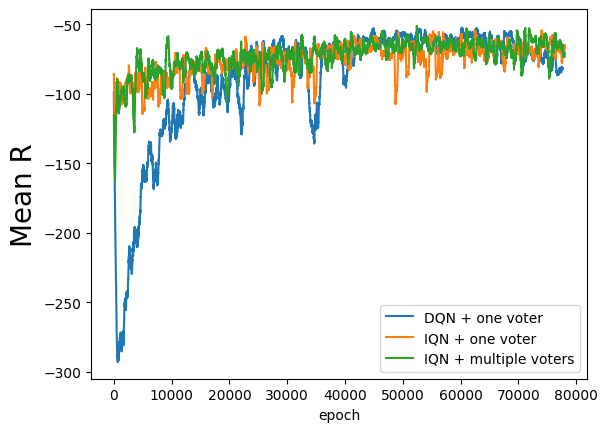

In [54]:
labels = ['DQN + one voter', 'IQN + one voter', 'IQN + multiple voters']

alpha = 0.2
wsize = 500
for ixs, d in enumerate(collective_rs_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.ylabel('Mean R', fontsize=20)
plt.xlabel('epoch')
# plt.title('Mean R')

NameError: name 'collective_processed' is not defined

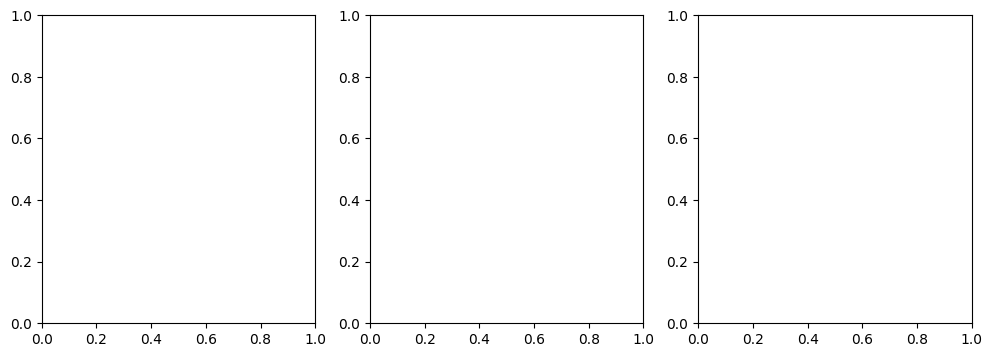

In [53]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(labels)):
    for j in range(len(collective_processed[i])):
        axes[i].plot(rolling_average(collective_processed[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Reward')

encounter: all resources

Text(0.5, 0.98, 'Encounters (by Badness level)')

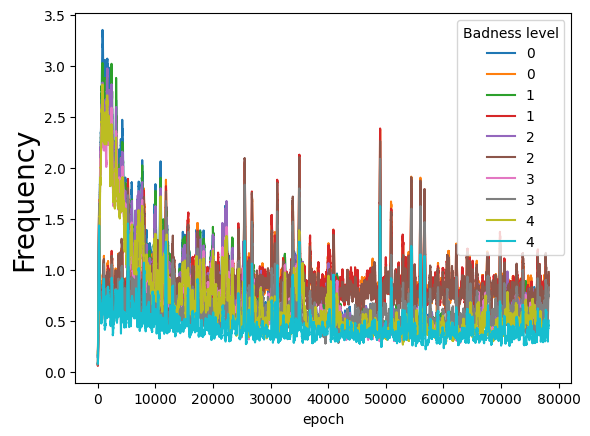

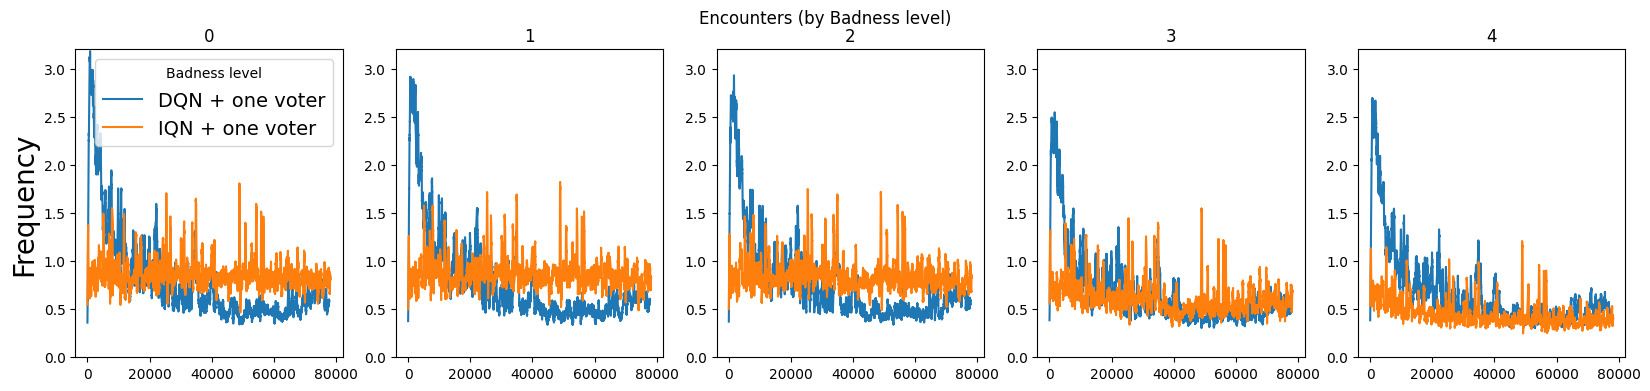

In [55]:
folders = [
       'Study1_experiment_cond_v3_one_voter_dqn_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250723-17071753304408',
    'Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-20071753056106',
   # 'Study1_experiment_cond_v3_AB0harm_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-19071753055581'
]
entity_names = ['Encounters_A', 'Encounters_B', 'Encounters_C', 'Encounters_D', 'Encounters_E']
total_all_entities = {}

for entity_name in entity_names:
    total = [[] for _ in range(len(folders))]

    for ixs, folder in enumerate(folders):

        parent_dir = os.path.join('res', folder)
        items = os.listdir(parent_dir)

        for item in items:

            if entity_name in item:

                sub_dir = os.path.join(parent_dir, item)            
                file = os.listdir(sub_dir)[0]
                data = pd.read_csv(os.path.join(sub_dir, file))
                total[ixs].append(data['Value'].to_numpy()[:]) # trim if needed

    total_avg = [np.mean(trim_and_calculate_mean(total[i]), axis=0) for i in range(len(total))]
    total_all_entities[entity_name] = total_avg

# plot all entities in the same figure, not subplots
wsize = 200
for badness_level, entity_name in enumerate(entity_names):
    for ixs, d in enumerate(total_all_entities[entity_name]):
        # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
        plt.plot(rolling_average(d, wsize), label=badness_level)
plt.legend(title='Badness level')
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('epoch')


# in a separate figure, plot all entities in subplots, make sure the yaxis is the same
fig, axes = plt.subplots(1, len(entity_names), figsize=(4*len(entity_names),4))
wsize = 300
for i in range(len(entity_names)):
    for j in range(len(total_all_entities[entity_names[i]])):
        axes[i].plot(rolling_average(total_all_entities[entity_names[i]][j], wsize), label=['DQN + one voter', 'IQN + one voter', 'IQN + multiple voters'][j])
    axes[i].set_title(i)
    if i == 0:
        axes[i].set_ylabel('Frequency', fontsize=20)
        axes[i].legend(title='Badness level', fontsize=14)
        # axes[i].set_xlabel('epoch', fontsize=20)
    axes[i].set_ylim([0, 3.2])

plt.suptitle('Encounters (by Badness level)')

encounter_coins

In [100]:
folders = [
    'Study1_experiment_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250507-18051746658070',
]

entity_name = '_A'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)            
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:]) # trim if needed

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (22,) + inhomogeneous part.

In [125]:
# combine different checkpoints

folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]
folders_all = [folders_1, folders_2, folders_3]


entity_name = 'Coin'
agents_num = [3, 3, 3, 3] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'Coin')

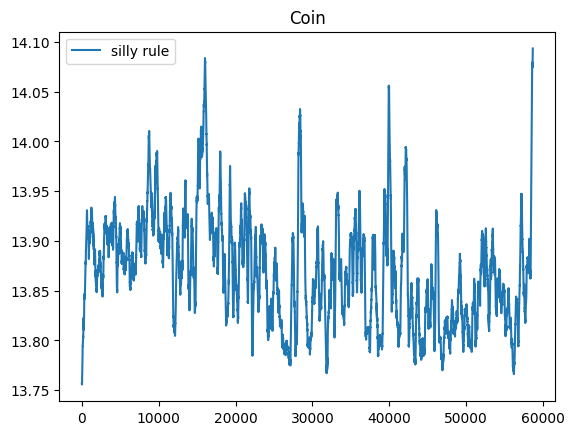

In [19]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']
labels = ['single_view & simple_actions', 'single_view & compound_actions', 'stacked_views & simple_actions', 'stacked_views & compound_actions']
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']

alpha = 0.2
wsize = 400
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Coin')

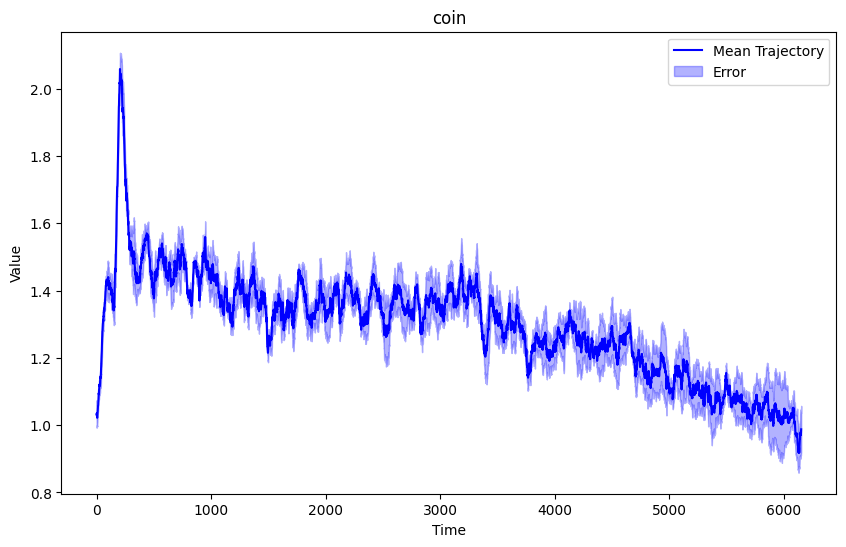

In [10]:
smoothed_collective_= [rolling_average(d, 50) for d in collective_]
plot_average_trajectory(smoothed_collective_, 'sem', title='coin')

IndexError: list index out of range

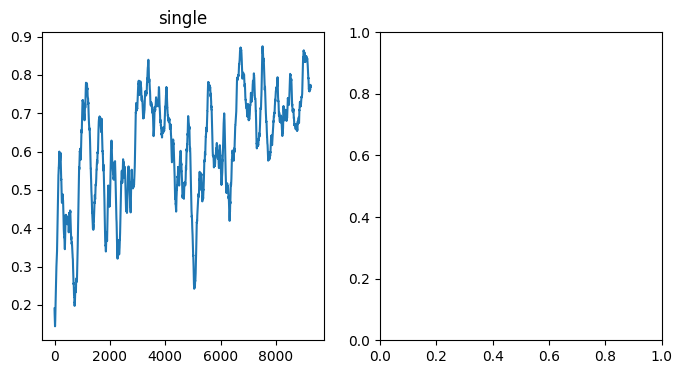

In [30]:
# plot
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 200
for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Coin')


Gem

In [39]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

entity_name = 'Gem'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:])

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

In [123]:
# combine different checkpoints

folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]
folders_all = [folders_1, folders_2, folders_3]

entity_name = 'Gem'
agents_num = [2,3,6] # specify the number of agents in each condition
agents_num = [3, 3,3, 3]
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'Gem')

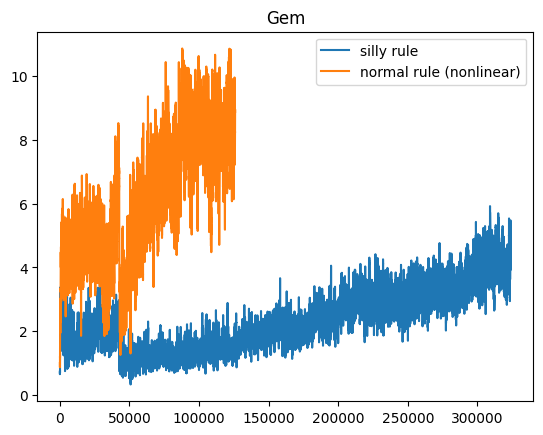

In [124]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']
labels = ['single_view & simple_actions', 'single_view & compound_actions', 'stacked_views & simple_actions', 'stacked_views & compound_actions']
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']


alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Gem')

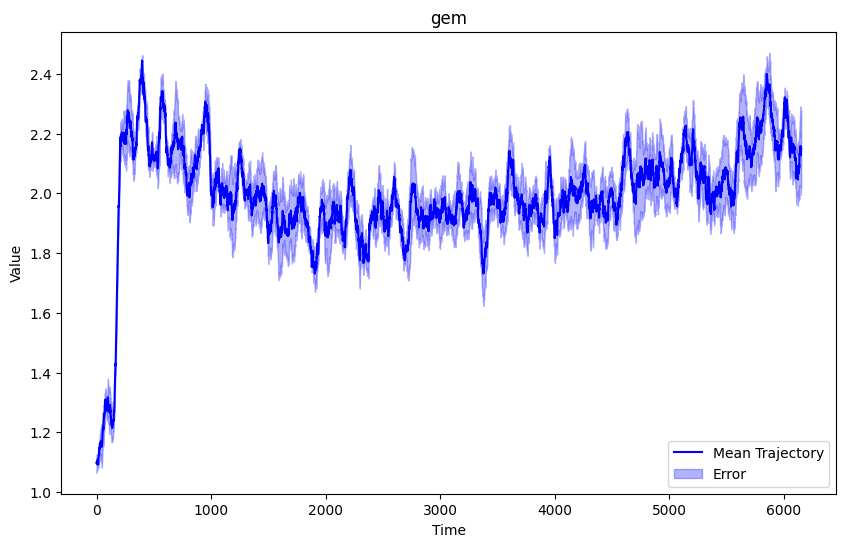

In [13]:
smoothed_collective_= [rolling_average(d, 50) for d in collective_]
plot_average_trajectory(smoothed_collective_, 'sem', title='gem')

Text(0.5, 0.98, 'Gem')

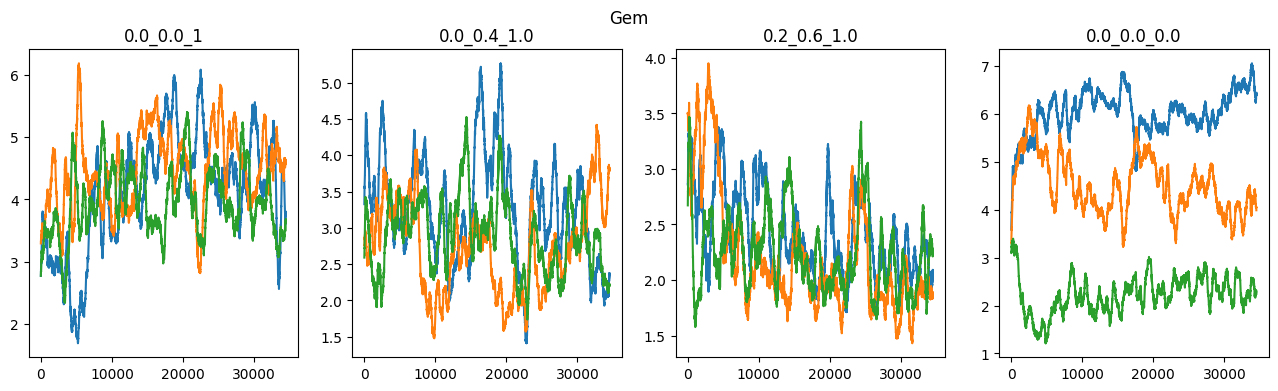

In [23]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 500

for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Gem')

bone

In [33]:
folders = [
    'testvote_withseparateTime_boostrap_withEndDone_test2agents_20241219-11121734627418',
    'testvote_withseparateTime_boostrap_withEndDone_test3agents_20241209-21121733796887',
    'testvote_withseparateTime_boostrap_withEndDone_test6agents_20241211-09121733926918',
]

entity_name = 'Bone'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:])

collective_ = [np.mean(collective[i], axis=0) for i in range(len(collective))]

/Users/socialai2/miniconda3/envs/state_punishment/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/socialai2/miniconda3/envs/state_punishment/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [127]:
# combine different checkpoints

folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]
folders_all = [folders_1, folders_2, folders_3]

entity_name = 'Bone'
agents_num = [2,3,6] # specify the number of agents in each condition
agents_num = [3, 3,3, 3]

collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'Bone')

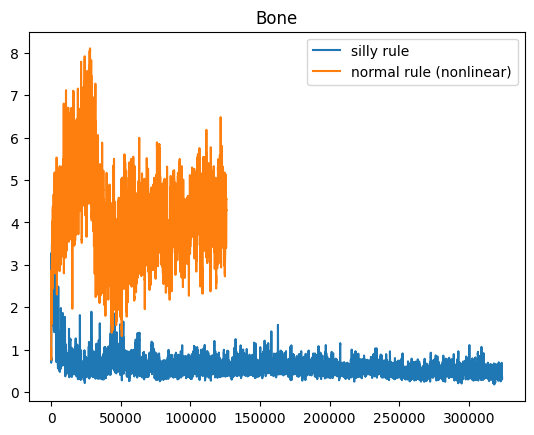

In [128]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']


alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Bone')

Text(0.5, 0.98, 'Bone')

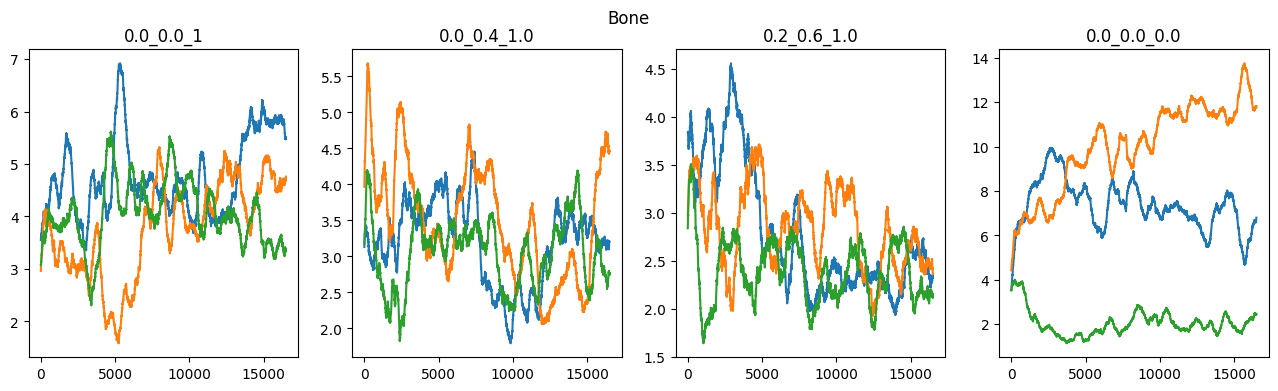

In [137]:
fig, axes = plt.subplots(1, len(labels), figsize=(4*len(labels),4))
wsize = 500

for i in range(len(labels)):
    for j in range(len(collective[i])):
        axes[i].plot(rolling_average(collective[i][j], wsize))
    axes[i].set_title(labels[i])
plt.suptitle('Bone')

wall

In [57]:
folders = [
    'Study1_experiment_cond_v3_one_voter_dqn_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250723-17071753304408',
    'Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-20071753056106',
    'Study1_experiment_cond_v3_AB0harm_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-19071753055581'
]

entity_name = 'Wall'
collective = [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):

    parent_dir = os.path.join('res', folder)
    items = os.listdir(parent_dir)

    for item in items:

        if entity_name in item:

            sub_dir = os.path.join(parent_dir, item)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective[ixs].append(data['Value'].to_numpy()[:])

collective_ = [np.mean(trim_and_calculate_mean(collective[i]), axis=0) for i in range(len(collective))]

In [129]:
# combine different checkpoints

folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]
folders_all = [folders_1, folders_2, folders_3]

entity_name = 'Wall'
agents_num = [3,3,3] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0, 0.5, 'Frequency')

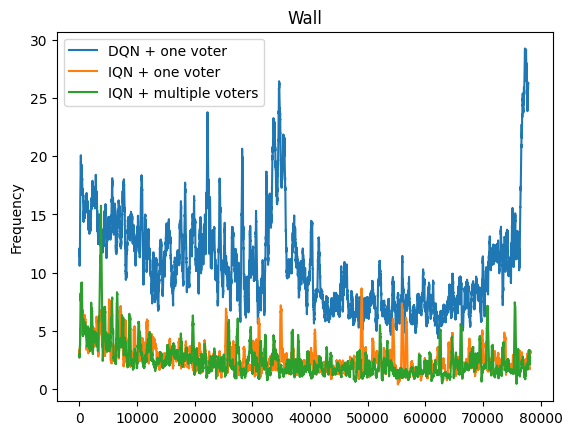

In [58]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']
labels = ['silly rule', 'important rule', 'important rule (transfer)']
labels = ['DQN + one voter', 'IQN + one voter', 'IQN + multiple voters']

alpha = 0.2
wsize = 300
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('Wall')
plt.ylabel('Frequency')
# plt.xticks([10000*i for i in range(11)], [f'{i}e+4' for i in range(11)], rotation=30);

state_punishment_level

Text(0.5, 0, 'epoch')

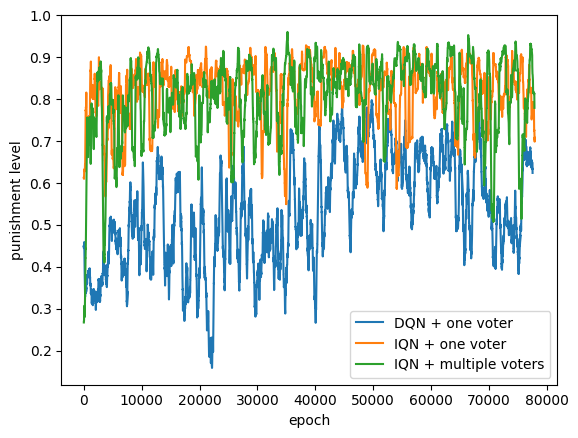

In [56]:
folders = [
    # "Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250603-11061748963658"
    'Study1_experiment_cond_v3_one_voter_dqn_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250723-17071753304408',
    'Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-20071753056106',
    'Study1_experiment_cond_v3_AB0harm_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-19071753055581'
]
collective = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'state_punishment_level_avg' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective[ixs].append(data['Value'].to_numpy()[:])
collective_ = [np.mean(trim_and_calculate_mean(collective[i]), axis=0) for i in range(len(collective))]

labels = ['DQN + one voter', 'IQN + one voter', 'IQN + multiple voters']


alpha = 0.2
wsize = 600
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.ylabel('punishment level')
plt.xlabel('epoch')
# plt.title('punishment prob (3 agents)')

compare single world and multi world versions

Text(0.5, 1.0, 'punishment prob (6 agents)')

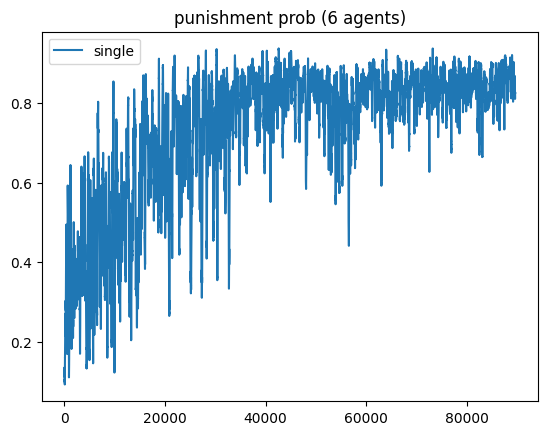

In [72]:
folders = [
    'test_voting_stacked_views_composite_actions_3agents_v0_resume_20250221-13021740163847'
]
collective = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'state_punishment_level_avg' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective[ixs].append(data['Value'].to_numpy()[:])
collective_ = [np.mean(trim_and_calculate_mean(collective[i]), axis=0) for i in range(len(collective))]

labels = ['single', 'parallel']


alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('punishment prob (6 agents)')

In [131]:
# combine different checkpoints
folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]
folders_all = [folders_1, folders_2, folders_3]

entity_name = 'state_punishment_level_avg'
agents_num = [3,3,3,3] # specify the number of agents in each condition
collective = [[] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    try: 
                        file = os.listdir(sub_dir)[0]
                        # data = pd.read_csv(os.path.join(sub_dir, file))
                    except: 
                        data = pd.read_csv(sub_dir)
                    
                    collective[ixs].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*condition_data)))] for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

In [121]:
collective_processed[2].shape

(108124,)

Text(0.5, 1.0, 'punishment prob')

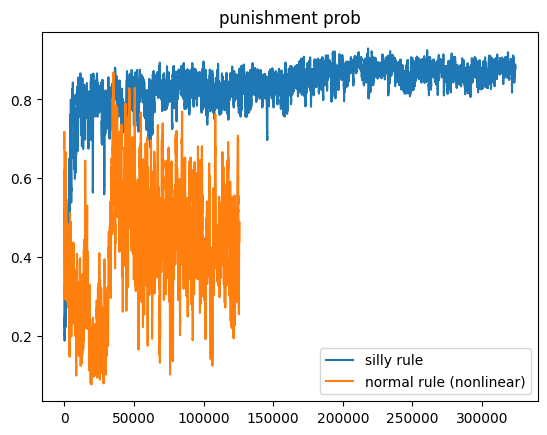

In [132]:
labels = ['composite', 'simple']
labels = ['single_view & simple_actions', 'single_view & compound_actions', 'stacked_views & simple_actions', 'stacked_views & compound_actions']
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']

alpha = 0.2
wsize = 300
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs])
plt.legend()
plt.title('punishment prob')

vote

In [59]:
# vote for punishment
folders = [
   'Study1_experiment_cond_v3_one_voter_dqn_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250723-17071753304408',
    'Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-20071753056106',
    'Study1_experiment_cond_v3_AB0harm_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-19071753055581'
]
collective_for = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'vote_for_punishment' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_for[ixs].append(data['Value'].to_numpy()[:])
collective_for_ = [np.mean(trim_and_calculate_mean(collective_for[i]), axis=0) for i in range(len(collective_for))]

In [134]:
# combine different checkpoints
folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]

folders_all = [folders_1, folders_2, folders_3]

entity_name = 'vote_for_punishment'
agents_num = [3,3,3] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    data = pd.read_csv(sub_dir)

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_for_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

In [60]:
# vote against punishment
folders = [
    'Study1_experiment_cond_v3_one_voter_dqn_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250723-17071753304408',
    'Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-20071753056106',
    'Study1_experiment_cond_v3_AB0harm_scheme_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3_20250720-19071753055581'

]
collective_against = [[] for _ in range(len(folders))]
for ixs, folder in enumerate(folders):
    parent_dir = os.path.join('res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'vote_against_punishment' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_against[ixs].append(data['Value'].to_numpy()[:])
collective_against_ = [np.mean(trim_and_calculate_mean(collective_against[i]), axis=0) for i in range(len(collective_against))]

In [135]:
# combine different checkpoints
folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224849',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s1_r2_seed3_20250305-20031741224789'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710514',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_r2_seed3_20250311-12031741710659'
]
folders_3 = [
    'test_study1__dynamic_with_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801143',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_s3_r2_seed3_20250312-13031741801219'
]

folders_all = [folders_1, folders_2, folders_3]

entity_name = 'vote_against_punishment'
agents_num = [3,3,3] # specify the number of agents in each condition
collective = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    data = pd.read_csv(sub_dir)

                    for a in range(len(collective[ixs])):
                        if f'Agent_{a}' in item:
                            collective[ixs][a].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in collective]
collective_against_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

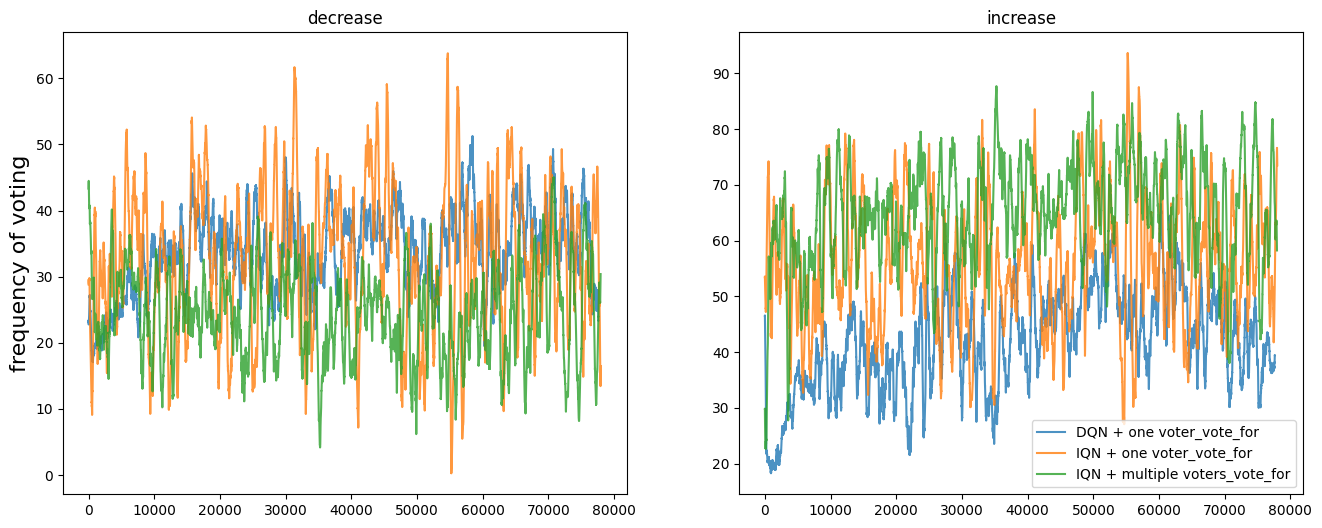

In [63]:
labels = ['2 Aagents', '3 Aagents', '6 Aagents']
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']
labels = ['DQN + one voter', 'IQN + one voter', 'IQN + multiple voters']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

alpha = 0.2
wsize = 500
for ixs, d in enumerate(collective_against_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    axes[0].plot(rolling_average(d, wsize), label=labels[ixs]+'_vote_against', alpha=0.8)
    #axes[0].set_ylim(0, 70)
for ixs, d in enumerate(collective_for_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    axes[1].plot(rolling_average(d, wsize), label=labels[ixs]+'_vote_for', alpha=0.8)
    #axes[1].set_ylim(0, 80)
# plt.legend()
axes[0].set_ylabel('frequency of voting', fontsize=16)
axes[0].set_title('decrease')
axes[1].set_title('increase')
plt.legend()

d prime


In [75]:
# combine different checkpoints
folders_1 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_20250301-17031740866784',
    'test_study1__fixed_only_taboo_stacked_view_simple_actions_3agents_respawn_0.04_v0_20250302-17031740953710',
    'test_study1__nondynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_20250228-11021740761664'
]
folders_2 = [
    'test_study1__dynamic_stacked_view_simple_actions_3agents_respawn_0.04_v0_s2_20250304-11031741106683'
    '',
    ''
]
# folders_1 = [
#     'test_voting_single_view_simple_actions_3agents_v0_20250219-16021740001974',
#     'test_voting_single_view_composite_actions_3agents_v0_20250219-16021740001897',
#     'test_voting_stacked_views_simple_actions_3agents_v0_20250219-15021739996204',
#     'test_voting_stacked_views_composite_actions_3agents_v0_20250219-16021739998907'
# ]

# folders_2 = [
#     '',
#     'test_voting_single_view_composite_actions_3agents_v0_resume_20250221-13021740163849',
#     '',
#     'test_voting_stacked_views_composite_actions_3agents_v0_resume_20250221-13021740163847'
# ]
folders_all = [folders_1, folders_2]

entity_name = 'd_prime'
agents_num = [3,3,3,3] # specify the number of agents in each condition
collective = [[] for folder_ixs in range(len(folders_1))]


for folders_ixs, folders in enumerate(folders_all):
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join('res', folder)
            items = os.listdir(parent_dir)

            for item in items:

                if entity_name in item:

                    sub_dir = os.path.join(parent_dir, item)
                    try: 
                        file = os.listdir(sub_dir)[0]
                        # data = pd.read_csv(os.path.join(sub_dir, file))
                    except: 
                        data = pd.read_csv(sub_dir)
                    
                    collective[ixs].append(data['Value'].to_numpy()[:])

collective_processed = [[np.array(list(itertools.chain(*condition_data)))] for condition_data in collective]
collective_ = [np.mean(trim_and_calculate_mean(collective_processed[i]), axis=0) for i in range(len(collective_processed))]

Text(0.5, 1.0, 'd prime')

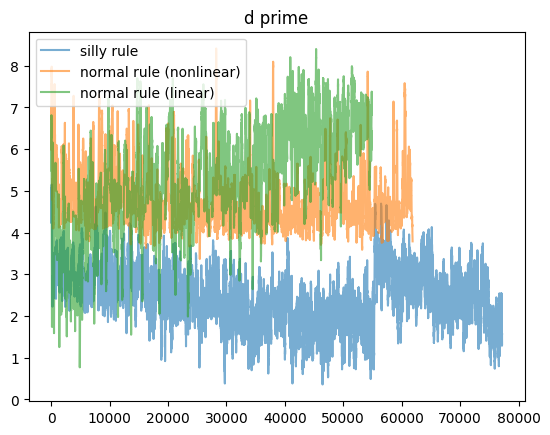

In [78]:
labels = ['silly rule', 'normal rule (nonlinear)', 'normal rule (linear)']

alpha = 0.2
wsize = 100
for ixs, d in enumerate(collective_):
    # plt.plot(exponential_moving_average(d, alpha), label=labels[ixs])
    plt.plot(rolling_average(d, wsize), label=labels[ixs], alpha=0.6)
plt.legend()
plt.title('d prime')